In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/afaan-oromo-hate-speech-dataset/Afaan Oromo Hate Speech Dataset.csv


In [2]:
import pandas as pd # read the csv
import seaborn as sns
import matplotlib.pyplot as plt
import re # regex to detect username, url, html entity 
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

from keras.utils import to_categorical
from keras import backend as K

In [3]:
all_data = pd.read_csv("/kaggle/input/afaan-oromo-hate-speech-dataset/Afaan Oromo Hate Speech Dataset.csv")
all_data.head()
label_encoder = LabelEncoder()

# Encode string labels to numerical categories
all_data['Labels'] = label_encoder.fit_transform(all_data['Labels'])

In [4]:
print(f"num of data: {all_data.shape}")

num of data: (20000, 2)


In [5]:
posts = all_data['Posts']
labels = all_data['Labels']

In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Posts   20000 non-null  object
 1   Labels  20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


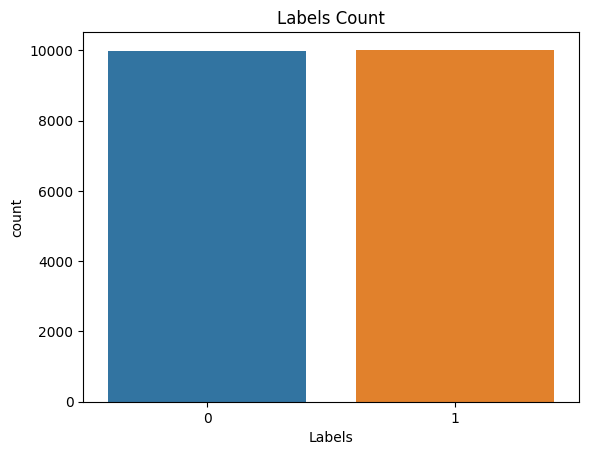

In [7]:
sns.countplot(x='Labels', data=all_data)
plt.title('Labels Count')
plt.show()

In [8]:
# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    clean = [remove_noise_symbols(text) for text in datas]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [9]:
clean_post = preprocess(posts)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(clean_post, labels, test_size=0.2, random_state=42)

In [11]:
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [12]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [13]:
# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=2)
y_train = to_categorical(y_train, num_classes=2)

In [14]:
# another look on the number of tweet in test and training data

print(f"num test posts: {y_test.shape[0]}")
print(f"num train posts: {y_train.shape[0]}")

num test posts: 4000
num train posts: 16000


In [15]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [16]:
# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(2, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [17]:
# checking the model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 591, 200)          11843400  
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 11919818 (45.47 MB)
Trainable params: 1191

In [18]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
250/250 [==============================] - 201s 785ms/step - loss: 0.4814 - accuracy: 0.7613 - f1: 0.7613 - precision: 0.7613 - recall: 0.7613 - val_loss: 0.3603 - val_accuracy: 0.8403 - val_f1: 0.8398 - val_precision: 0.8398 - val_recall: 0.8398
Epoch 2/10
250/250 [==============================] - 193s 773ms/step - loss: 0.2303 - accuracy: 0.9105 - f1: 0.9105 - precision: 0.9105 - recall: 0.9105 - val_loss: 0.3831 - val_accuracy: 0.8435 - val_f1: 0.8430 - val_precision: 0.8430 - val_recall: 0.8430
Epoch 3/10
250/250 [==============================] - 196s 784ms/step - loss: 0.1175 - accuracy: 0.9439 - f1: 0.9439 - precision: 0.9439 - recall: 0.9439 - val_loss: 0.5952 - val_accuracy: 0.8152 - val_f1: 0.8145 - val_precision: 0.8145 - val_recall: 0.8145
Epoch 4/10
250/250 [==============================] - 197s 787ms/step - loss: 0.0919 - accuracy: 0.9542 - f1: 0.9542 - precision: 0.9542 - recall: 0.9542 - val_loss: 0.7617 - val_accuracy: 0.8202 - val_f1: 0.8199 - val_precisi

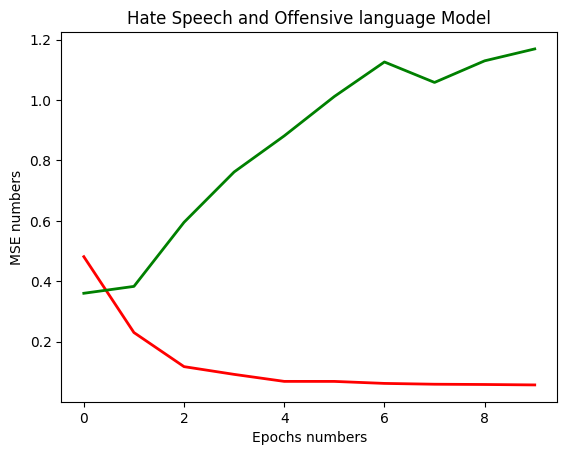

In [19]:
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [20]:
model.predict(X_test)

125/125 [==============================] - 10s 80ms/step


array([[9.9999934e-01, 5.6342412e-07],
       [1.6431876e-04, 9.9983573e-01],
       [3.7584113e-04, 9.9962419e-01],
       ...,
       [2.2432553e-03, 9.9775672e-01],
       [4.2922255e-01, 5.7077736e-01],
       [6.2766736e-03, 9.9372327e-01]], dtype=float32)